In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_dir = '/content/drive/MyDrive/VIPERC/dataset/train'
test_dir = '/content/drive/MyDrive/VIPERC/dataset/test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Đọc dữ liệu từ thư mục và áp dụng one-hot encoding cho nhãn
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Số lượng lớp trong dữ liệu
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

Found 5025 images belonging to 13 classes.
Found 1256 images belonging to 13 classes.
Number of classes: 13


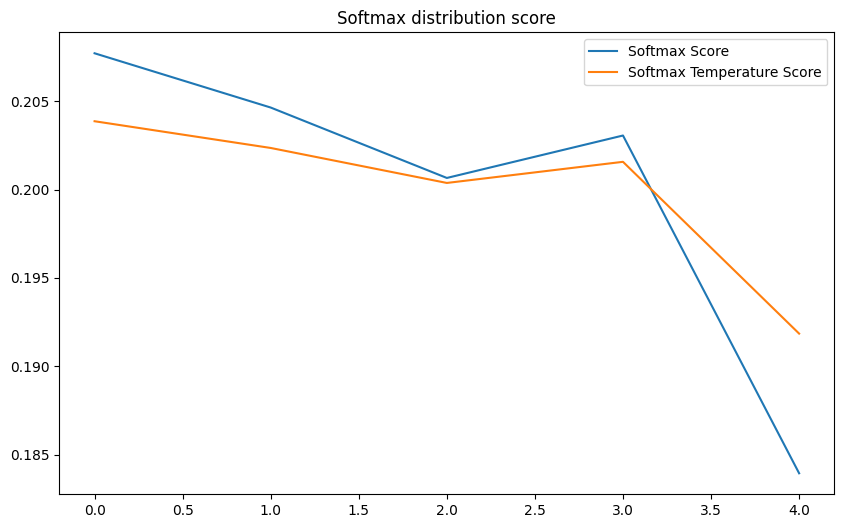

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize random probability distribution
x = np.random.rand(5)
x = x/np.sum(x)

def softmax(x):
  score = np.exp(x)/np.sum(np.exp(x))
  return score

def softmax_scale(x, temp):
  x = [i/temp for i in x]
  score_scale = softmax(x)
  return score_scale

score_1 = softmax(x)
score_2 = softmax_scale(x, 2)

def _plot_line(score1, score2):
  assert len(score1) == len(score2)
  classes = np.arange(len(score1))
  plt.figure(figsize=(10, 6))
  plt.plot(classes, score1, label="Softmax Score")
  plt.plot(classes, score2, label = "Softmax Temperature Score")
  # plt.ylim([0, 1])
  plt.legend()
  plt.title("Softmax distribution score")
  plt.show()

_plot_line(score_1, score_2)

In [5]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers

class Distiller(keras.Model):
    def __init__(self, student, teacher):
      """
      teacher: teacher model
      student: student model
      """
      super(Distiller, self).__init__()
      self.teacher = teacher
      self.student = student

    def compile(
      self,
      optimizer,
      metrics,
      student_loss_fn,
      distillation_loss_fn,
      alpha=0.1,
      temperature=3,
    ):
      """ Configure the distiller.

      Args:
          optimizer: Keras optimizer for the student weights
          metrics: Keras metrics for evaluation
          student_loss_fn: Loss function of difference between student
              predictions and ground-truth
          distillation_loss_fn: Loss function of difference between soft
              student predictions and soft teacher predictions
          alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
          temperature: Temperature for softening probability distributions.
              Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.alpha = alpha
      self.temperature = temperature

    def train_step(self, data):
      # Unpack data
      x, y = data

      # Forward pass of teacher
      teacher_predictions = self.teacher(x, training=False)

      with tf.GradientTape() as tape:
          # Forward pass of student
          student_predictions = self.student(x, training=True)

          # Compute losses
          student_loss = self.student_loss_fn(y, student_predictions)
          distillation_loss = self.distillation_loss_fn(
              tf.nn.softmax(teacher_predictions / self.temperature, axis=1), # soft label from teacher
              tf.nn.softmax(student_predictions / self.temperature, axis=1), # soft prediction from student
          )
          loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

      # Compute gradients
      trainable_vars = self.student.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update the metrics configured in `compile()`.
      self.compiled_metrics.update_state(y, student_predictions)

      # Return a dict of performance
      results = {m.name: m.result() for m in self.metrics}
      results.update(
          {"student_loss": student_loss, "distillation_loss": distillation_loss}
      )
      return results

    def test_step(self, data):
      # Unpack the data
      x, y = data

      # Compute predictions
      y_prediction = self.student(x, training=False)

      # Calculate the loss
      student_loss = self.student_loss_fn(y, y_prediction)

      # Update the metrics.
      self.compiled_metrics.update_state(y, y_prediction)

      # Return a dict of performance
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss})
      return results

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import NASNetMobile


teacher = load_model('/content/drive/MyDrive/VIPERC/models/vgg19.keras')

base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

student = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
], name='student')

student.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
class SaveBestStudentModel(keras.callbacks.Callback):
    def __init__(self, save_path, monitor='val_student_loss'):
        super(SaveBestStudentModel, self).__init__()
        self.save_path = save_path
        self.monitor = monitor
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current < self.best:
            self.best = current
            self.model.student.save(self.save_path)

save_best_student_model = SaveBestStudentModel('best_model.keras')

In [8]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_student_loss', patience=5, restore_best_weights=True)

# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.CategoricalAccuracy()],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(train_generator, epochs=80, validation_data=test_generator, callbacks=[early_stopping, save_best_student_model])

# Evaluate student on test dataset
distiller.evaluate(test_generator)

Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


158/158 [==============================] - 76s 317ms/step - categorical_accuracy: 0.9100 - student_loss: 0.2962 - distillation_loss: 4.8626e-05 - val_categorical_accuracy: 0.9554 - val_student_loss: 0.1302
Epoch 2/80
158/158 [==============================] - 42s 267ms/step - categorical_accuracy: 0.9835 - student_loss: 0.0523 - distillation_loss: 9.5819e-06 - val_categorical_accuracy: 0.9666 - val_student_loss: 0.0670
Epoch 3/80
158/158 [==============================] - 39s 249ms/step - categorical_accuracy: 0.9912 - student_loss: 0.0300 - distillation_loss: 6.9211e-06 - val_categorical_accuracy: 0.9729 - val_student_loss: 0.2517
Epoch 4/80
158/158 [==============================] - 43s 269ms/step - categorical_accuracy: 0.9932 - student_loss: 0.0222 - distillation_loss: 6.0190e-06 - val_categorical_accuracy: 0.9793 - val_student_loss: 0.0327
Epoch 5/80
158/158 [==============================] - 39s 248ms/step - categorical_accuracy: 0.9944 - student_loss: 0.0155 - distillation_loss:

[0.9792993664741516, 0.032735034823417664]

In [9]:
!mv /content/best_model.keras /content/drive/MyDrive/VIPERC/models/

In [10]:
from tensorflow.keras.models import load_model

best_model = load_model('/content/drive/MyDrive/VIPERC/models/best_model.keras')

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

class_labels = list(test_generator.class_indices.keys())
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Lấy nhãn thực tế từ generator
true_classes = test_generator.classes

# Tính các chỉ số đánh giá
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# In ra kết quả
print('Accuracy:', accuracy * 100)
print('Precision:', precision * 100)
print('Recall:', recall * 100)
print('F1 Score:', f1* 100)

# In báo cáo chi tiết
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Tính accuracy cho từng nhãn
conf_matrix = confusion_matrix(true_classes, predicted_classes)
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print('\nAccuracy for each class:')
for class_name, class_accuracy in zip(class_labels, class_accuracies):
    print(f'{class_name}: {class_accuracy:.2f}')

40/40 [==============================] - 11s 156ms/step - loss: 0.0672 - categorical_accuracy: 0.9793

Test Loss: 0.0672
Test Accuracy: 97.93%
40/40 [==============================] - 10s 148ms/step
Accuracy: 97.92993630573248
Precision: 97.95981452389796
Recall: 97.92993630573248
F1 Score: 97.92129200330962

Classification Report:
              precision    recall  f1-score   support

 cong_chieng       1.00      1.00      1.00        60
     dan_bau       0.99      1.00      0.99        79
      dan_co       0.98      0.89      0.93        47
      dan_da       0.99      0.98      0.98       123
     dan_day       0.98      0.99      0.98        92
  dan_nguyet       0.96      0.94      0.95       125
     dan_sen       0.93      0.98      0.96       131
  dan_t_rung       1.00      0.99      1.00       171
    dan_tinh       0.98      1.00      0.99       124
   dan_tranh       0.98      0.98      0.98       164
   dan_ty_ba       1.00      0.92      0.96        48
        khen     